# Import the libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import cv2 as cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from collections import Counter
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
import torch


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

In [2]:
def load_yolo_labels(label_dir, file_names):
    labels = {}
    for name in file_names:
        txt_name = os.path.splitext(name)[0] + ".txt"
        txt_path = os.path.join(label_dir, txt_name)
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                line = f.readline()
                if line.strip():
                    labels[name] = int(line.split()[0])
                else:
                    labels[name] = 0
        else:
            labels[name] = 0
    return labels

In [3]:
train_data = np.load("/kaggle/input/rl-features/train_features.npz", allow_pickle=True)
features = train_data['features']
file_names = train_data['file_names']
train_labels = load_yolo_labels("/kaggle/input/cbis-dataset/train/labels", file_names)
# ✅ 3. Нормализация признаков
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [44]:
# ✅ 4. Загрузка валидационного набора
valid_data = np.load("/kaggle/input/rl-features/valid_features.npz", allow_pickle=True)
valid_features = valid_data['features']
valid_file_names = valid_data['file_names']
valid_labels = load_yolo_labels("/kaggle/input/cbis-dataset/valid/labels", valid_file_names)
valid_features = scaler.transform(valid_features)

In [45]:
# ✅ 5. Проверка меток
print("Train label distribution:", Counter(train_labels.values()))
print("Valid label distribution:", Counter(valid_labels.values()))

Train label distribution: Counter({0: 505, 1: 486})
Valid label distribution: Counter({1: 95, 0: 80})


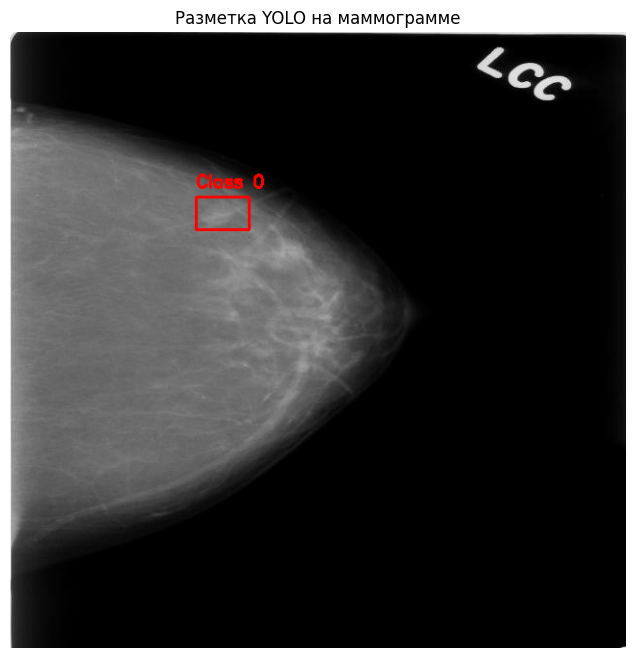

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

# Пути
img_path = "/kaggle/input/cbis-dataset/valid/images/P_00021_LEFT_CC_Original__png.rf.95a459b3dfbd2a9af081c30316b1ed0c.jpg"
label_path = "/kaggle/input/cbis-dataset/valid/labels/P_00021_LEFT_CC_Original__png.rf.95a459b3dfbd2a9af081c30316b1ed0c.txt"

# Загрузка изображения
image = cv2.imread(img_path)
h, w = image.shape[:2]

# Загрузка и парсинг label-файла
with open(label_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    parts = line.strip().split()
    cls_id = int(parts[0])
    x_center, y_center, box_w, box_h = map(float, parts[1:])

    # Преобразование относительных координат в пиксели
    x1 = int((x_center - box_w / 2) * w)
    y1 = int((y_center - box_h / 2) * h)
    x2 = int((x_center + box_w / 2) * w)
    y2 = int((y_center + box_h / 2) * h)

    # Отрисовка рамки
    color = (0, 0, 255)  # Красный
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(image, f"Class {cls_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Отображение
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Разметка YOLO на маммограмме")
plt.axis("off")
plt.show()
#[a]

# Grid Cam 

In [7]:
# import os
# import cv2
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# from PIL import Image
# from torchvision import models, transforms

# # === YOLO: преобразование координат ===
# def yolo_to_bbox(yolo_line, img_width, img_height):
#     class_id, cx, cy, w, h = map(float, yolo_line.strip().split())
#     x1 = int((cx - w / 2) * img_width)
#     y1 = int((cy - h / 2) * img_height)
#     x2 = int((cx + w / 2) * img_width)
#     y2 = int((cy + h / 2) * img_height)
#     return int(class_id), x1, y1, x2, y2

# # === Подготовка модели ===
# model = models.efficientnet_b0(pretrained=True)
# model.eval()

# # === Grad-CAM функция ===
# def generate_heatmap(model, image_tensor, target_class):
#     image_tensor = image_tensor.unsqueeze(0)
#     image_tensor.requires_grad_()

#     activations = []
#     gradients = []

#     def forward_hook(module, input, output):
#         activations.append(output)

#     def backward_hook(module, grad_in, grad_out):
#         gradients.append(grad_out[0])

#     # Подключаемся к последнему сверточному слою
#     target_layer = model.features[-1]
#     handle_f = target_layer.register_forward_hook(forward_hook)
#     handle_b = target_layer.register_full_backward_hook(backward_hook)

#     # Forward
#     output = model(image_tensor)
#     model.zero_grad()
#     class_loss = output[0, target_class]
#     class_loss.backward()

#     # Grad-CAM
#     grads = gradients[0].cpu().detach().numpy()[0]
#     fmap = activations[0].cpu().detach().numpy()[0]

#     weights = np.mean(grads, axis=(1, 2))
#     cam = np.sum(weights[:, None, None] * fmap, axis=0)
#     cam = np.maximum(cam, 0)

#     cam = cv2.resize(cam, (image_tensor.shape[2], image_tensor.shape[3]))
#     cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
#     cam = np.uint8(255 * cam)
#     heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

#     handle_f.remove()
#     handle_b.remove()

#     return heatmap

# # === Преобразования ===
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]
#     ),
# ])

# # === Пути ===
# img_path = "/kaggle/input/cbis-dataset/valid/images/P_00021_LEFT_CC_Original__png.rf.95a459b3dfbd2a9af081c30316b1ed0c.jpg"
# label_path = "/kaggle/input/cbis-dataset/valid/labels/P_00021_LEFT_CC_Original__png.rf.95a459b3dfbd2a9af081c30316b1ed0c.txt"

# # === Подготовка изображения ===
# image_pil = Image.open(img_path).convert("RGB")
# image_tensor = transform(image_pil)
# img_width, img_height = image_pil.size

# # === Предсказание класса ===
# with torch.no_grad():
#     output = model(image_tensor.unsqueeze(0))
#     predicted_class = output.argmax(dim=1).item()

# # === Генерация тепловой карты ===
# heatmap = generate_heatmap(model, image_tensor, predicted_class)

# # === Подготовка фонового изображения (в RGB) ===
# image_np = np.array(image_pil.resize((224, 224)))
# overlay = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

# # === Отрисовка YOLO рамки ===
# if os.path.exists(label_path):
#     with open(label_path) as f:
#         for line in f:
#             class_id, x1, y1, x2, y2 = yolo_to_bbox(line, 224, 224)
#             overlay = cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)
#             overlay = cv2.putText(overlay, f"Class {class_id}", (x1, y1 - 10),
#                                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# # === Отображение ===
# plt.figure(figsize=(6, 6))
# plt.imshow(overlay)
# plt.title("Grad-CAM + YOLO")
# plt.axis("off")
# plt.show()


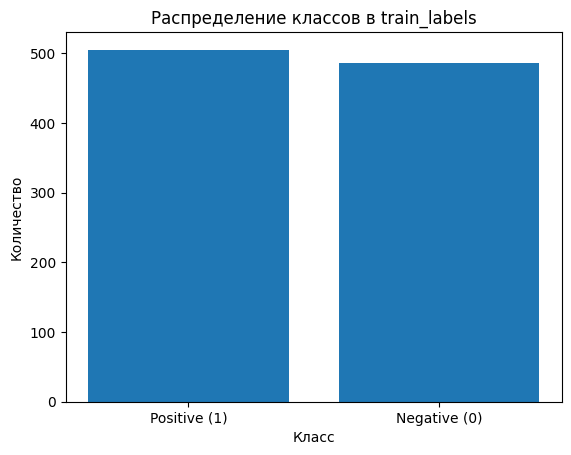

In [8]:
import matplotlib.pyplot as plt

counts = Counter(train_labels.values())
plt.bar(counts.keys(), counts.values(), tick_label=['Negative (0)', 'Positive (1)'])
plt.title("Распределение классов в train_labels")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()


In [9]:
# Добавьте после загрузки меток
def analyze_class_distribution(labels_dict):
    values = list(labels_dict.values())
    unique, counts = np.unique(values, return_counts=True)
    print(f"Распределение классов: {dict(zip(unique, counts))}")
    return dict(zip(unique, counts))

train_dist = analyze_class_distribution(train_labels)
valid_dist = analyze_class_distribution(valid_labels)

Распределение классов: {0: 505, 1: 486}
Распределение классов: {0: 80, 1: 95}


# Breast cancer env

In [47]:


class BreastCancerEnv(gym.Env):
    def __init__(self, features, labels_dict, file_names, episode_length=30, reward_config=None):
        super(BreastCancerEnv, self).__init__()
        self.features = features
        self.labels_dict = labels_dict
        self.file_names = file_names
        self.episode_length = episode_length
        self.reward_config = reward_config or {
            'TP': 1.0,
            'TN': 0.5,
            'FP': -1.0,
            'FN': -2.0
        }

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(features.shape[1],), dtype=np.float32
        )
        self.action_space = spaces.Discrete(2)

        self.current_step = 0
        self.indices = []

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.indices = np.random.choice(len(self.features), self.episode_length, replace=False)
        self.current_step = 0
        idx = self.indices[self.current_step]
        return self.features[idx], {}

    def step(self, action):
        idx = self.indices[self.current_step]
        fname = self.file_names[idx]
        true_label = self.labels_dict.get(fname, 0)

        # Применяем reward_config
        if action == 1 and true_label == 1:
            reward = self.reward_config['TP']
        elif action == 0 and true_label == 0:
            reward = self.reward_config['TN']
        elif action == 1 and true_label == 0:
            reward = self.reward_config['FP']
        elif action == 0 and true_label == 1:
            reward = self.reward_config['FN']
        else:
            reward = -0.1  # fallback, если что-то пойдет не так

        self.current_step += 1
        done = self.current_step >= self.episode_length

        if not done:
            next_obs = self.features[self.indices[self.current_step]]
        else:
            next_obs = np.zeros_like(self.features[0])

        return next_obs, reward, done, False, {}


In [49]:
def evaluate_model_full(model, features, labels_dict, file_names, verbose=True):
    tp = tn = fp = fn = 0
    predictions = []
    truths = []

    for i in range(len(features)):
        state = features[i]
        fname = file_names[i]
        true_label = labels_dict.get(fname, 0)

        action, _ = model.predict(state, deterministic=True)
        action = int(action)

        predictions.append(action)
        truths.append(true_label)

        if action == 1 and true_label == 1:
            tp += 1
        elif action == 0 and true_label == 0:
            tn += 1
        elif action == 1 and true_label == 0:
            fp += 1
        elif action == 0 and true_label == 1:
            fn += 1

    steps = len(predictions)
    accuracy = (tp + tn) / steps if steps > 0 else 0

    if verbose:
        print(f"\n📊 Валидация на всей выборке:")
        print(f"Точность: {accuracy * 100:.2f}%")
        print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

    return accuracy, tp, tn, fp, fn, predictions, truths


In [50]:
# ✅ 5. Проверка меток
print("Train label distribution:", Counter(train_labels.values()))
print("Valid label distribution:", Counter(valid_labels.values()))

Train label distribution: Counter({0: 505, 1: 486})
Valid label distribution: Counter({1: 95, 0: 80})


In [63]:
%%time
# Создание среды
train_env = lambda: BreastCancerEnv(features, train_labels, file_names, episode_length=100)
valid_env = BreastCancerEnv(valid_features, valid_labels, valid_file_names, episode_length=100)

# Обёртка в make_vec_env
from stable_baselines3.common.env_util import make_vec_env
vec_env = make_vec_env(train_env, n_envs=1)

# Создание модели
model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=1e-4,
    gamma=0.95,
    n_steps=256,
    batch_size=64,
    ent_coef=0.01,
    tensorboard_log="./ppo_logs/"
)

# Обучение с валидацией каждые 10_000 шагов
total_timesteps = 150_000
validation_interval = 1_000
best_accuracy = 0
best_model_path = "best_model_ppo.zip"
val_history = []
for step in range(0, total_timesteps, validation_interval):
    model.learn(total_timesteps=validation_interval, reset_num_timesteps=False)
    acc, tp, tn, fp, fn, preds, trues = evaluate_model_full(model, valid_features, valid_labels, valid_file_names)
    val_history.append({
        "step": step + validation_interval,
        "accuracy": acc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
    })
    print(f"\n📊 Валидация на шаге {step + validation_interval}:")
    print(f"Точность: {acc * 100:.2f}%")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
    # ✅ Сохраняем модель, если улучшилась
    if acc > best_accuracy:
        best_accuracy = acc
        model.save(best_model_path)
        print(f"💾 Новая лучшая модель сохранена с точностью {acc * 100:.2f}%")


Using cuda device
Logging to ./ppo_logs/PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -43      |
| time/              |          |
|    fps             | 771      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 256      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 100          |
|    ep_rew_mean          | -40.5        |
| time/                   |              |
|    fps                  | 596          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 512          |
| train/                  |              |
|    approx_kl            | 7.609511e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.693       |
|    explain


📊 Валидация на всей выборке:
Точность: 67.43%
TP: 69, TN: 49, FP: 31, FN: 26
📋 Classification Report:

              precision    recall  f1-score   support

   No Cancer       0.65      0.61      0.63        80
      Cancer       0.69      0.73      0.71        95

    accuracy                           0.67       175
   macro avg       0.67      0.67      0.67       175
weighted avg       0.67      0.67      0.67       175



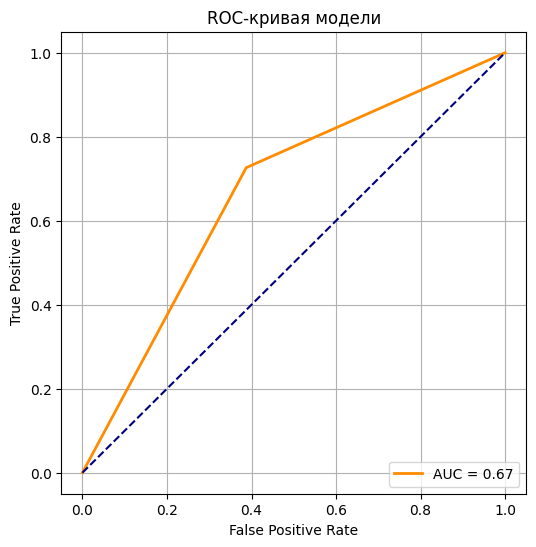

In [65]:
# Вызов функции оценки модели
_, _, _, _, _, preds, trues = evaluate_model_full(model, valid_features, valid_labels, valid_file_names)

# Теперь вызови построение отчёта и ROC-кривой
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Classification report
print("📋 Classification Report:\n")
print(classification_report(trues, preds, target_names=["No Cancer", "Cancer"]))

# ROC
fpr, tpr, _ = roc_curve(trues, preds)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая модели")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [67]:
from stable_baselines3 import PPO
model = PPO.load("/kaggle/working/best_model_ppo.zip")

acc, tp, tn, fp, fn, preds, trues = evaluate_model_full(model, valid_features, valid_labels, valid_file_names)



📊 Валидация на всей выборке:
Точность: 69.71%
TP: 72, TN: 50, FP: 30, FN: 23


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 145MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains

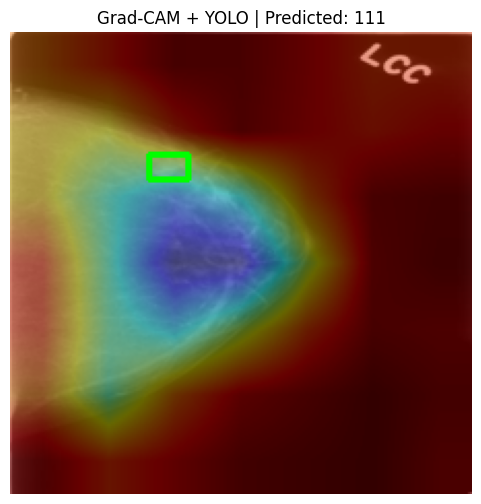

In [69]:

# === 1. Функция YOLO → bbox
def yolo_to_bbox(yolo_line, w, h):
    cls, cx, cy, bw, bh = map(float, yolo_line.strip().split())
    x1 = int((cx - bw / 2) * w)
    y1 = int((cy - bh / 2) * h)
    x2 = int((cx + bw / 2) * w)
    y2 = int((cy + bh / 2) * h)
    return int(cls), x1, y1, x2, y2

# === 2. Подготовка модели (EfficientNet)
model_cnn = models.efficientnet_b0(pretrained=True)
model_cnn.eval()

# Grad-CAM подготовка
activations = []
gradients = []

def forward_hook(module, input, output): activations.append(output)
def backward_hook(module, grad_in, grad_out): gradients.append(grad_out[0])

target_layer = model_cnn.features[-1]
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

# === 3. Выбираем пример (замени путь и имя)
img_name = valid_file_names[0]
img_path = f"/kaggle/input/cbis-dataset/valid/images/{img_name}"
label_path = f"/kaggle/input/cbis-dataset/valid/labels/{img_name.replace('.jpg', '.txt')}"

# Загрузка и преобразование
image_pil = Image.open(img_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
input_tensor = transform(image_pil).unsqueeze(0)
input_tensor.requires_grad_()

# === 4. Прямой и обратный проход
output = model_cnn(input_tensor)
class_id = output.argmax()
loss = output[0, class_id]
loss.backward()

# === 5. Grad-CAM расчет
grads = gradients[0].squeeze().detach().numpy()
acts = activations[0].squeeze().detach().numpy()
weights = np.mean(grads, axis=(1, 2))
cam = np.zeros(acts.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * acts[i]

cam = np.maximum(cam, 0)
cam = cv2.resize(cam, (224, 224))
cam -= cam.min()
cam /= cam.max()
cam = (cam * 255).astype(np.uint8)
heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

# === 6. Объединение изображения
original = np.array(image_pil.resize((224, 224)))
overlay = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

# === 7. Добавляем YOLO рамку
with open(label_path) as f:
    line = f.readline()
    _, x1, y1, x2, y2 = yolo_to_bbox(line, 224, 224)
    overlay = cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)

# === 8. Показываем
plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.title(f"Grad-CAM + YOLO | Predicted: {class_id.item()}")
plt.axis("off")
plt.show()


In [72]:
def generate_heatmap(model, image_tensor, target_class):
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor.requires_grad_()

    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Подключение к последнему сверточному слою
    target_layer = model.features[-1]  # для EfficientNet

    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_full_backward_hook(backward_hook)

    output = model(image_tensor)
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    grads = gradients[0].cpu().data.numpy()[0]
    fmap = activations[0].cpu().data.numpy()[0]

    weights = np.mean(grads, axis=(1, 2))
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * fmap[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image_tensor.shape[2], image_tensor.shape[3]))
    cam -= cam.min()
    cam /= cam.max()
    cam = (cam * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

    handle_f.remove()
    handle_b.remove()

    return heatmap


In [82]:
class DummyImageEnv(gym.Env):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.observation_space = spaces.Box(0, 1, shape=(3, 128, 128), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.idx = 0

    def reset(self, *, seed=None, options=None):
        self.idx = np.random.randint(0, len(self.images))
        obs = self.images[self.idx].numpy()  # ⬅️ ПРИВЕДЕНИЕ К np.ndarray
        return obs, {}

    def step(self, action):
        true_label = self.labels[self.idx]
        reward = 1 if action == true_label else -1
        done = True
        obs = self.images[self.idx].numpy()  # ⬅️ ПРИВЕДЕНИЕ К np.ndarray
        return obs, reward, done, False, {}


In [90]:
vec_env = DummyVecEnv([make_image_env])
vec_env = VecTransposeImage(vec_env)


AssertionError: The observation space must be an image or dictionary observation space

In [99]:
obs = vec_env.reset()
print(obs.shape)  # ✅ должно быть (1, 3, 128, 128)


(1, 3, 128, 128)


In [142]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from torchvision import transforms
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import make_vec_env
from gymnasium import spaces
import gymnasium as gym

# === 1. Кастомный CNN для Grad-CAM ===
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, features_dim),
            nn.ReLU()
        )
        self.activations = None

    def forward(self, x):
        x = self.conv(x)
        self.activations = x  # сохраняем активации
        return self.linear(x)

# === 2. Препроцессинг ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# === 3. Grad-CAM ===
def generate_grad_cam(model, image_tensor, target_class):
    model.policy.eval()  # ✅ корректно

    image_tensor = image_tensor.unsqueeze(0).to(device)
    image_tensor.requires_grad_()

    model.policy.features_extractor.activations = None

    with torch.set_grad_enabled(True):
        logits = model.policy.forward(image_tensor)[0]
        loss = logits[target_class]
        loss.backward()

        grads = model.policy.features_extractor.activations.grad[0]
        fmap = model.policy.features_extractor.activations[0]

        weights = grads.mean(dim=(1, 2))
        cam = torch.zeros_like(fmap[0])
        for i, w in enumerate(weights):
            cam += w * fmap[i]
        cam = F.relu(cam)
        cam = cam.detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam = cv2.resize(cam, (128, 128))
        return cam




# === 4. PPO Обучение ===
class DummyImageEnv(gym.Env):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.observation_space = spaces.Box(0, 1, shape=(3, 128, 128), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.idx = 0

    def reset(self, *, seed=None, options=None):
        self.idx = np.random.randint(0, len(self.images))
        return self.images[self.idx], {}

    def step(self, action):
        true_label = self.labels[self.idx]
        reward = 1 if action == true_label else -1
        done = True
        return self.images[self.idx], reward, done, False, {}

# === 5. Загрузка ===
# Замените пути на свои
image_paths = sorted([
    f"/kaggle/input/cbis-dataset/valid/images/{name}"
    for name in os.listdir("/kaggle/input/cbis-dataset/valid/images")
    if name.endswith(".jpg")
])
label_paths = [p.replace("images", "labels").replace(".jpg", ".txt") for p in image_paths]

images = []
labels = []
for img_path, lbl_path in zip(image_paths, label_paths):
    image = Image.open(img_path).convert("RGB")
    images.append(transform(image))
    with open(lbl_path) as f:
        label = int(f.readline().split()[0])
        labels.append(label)

# === 6. Обучение PPO ===
# ✅ Убедимся, что фичи и модель на одном устройстве
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Инициализация окружения и модели
train_env = lambda: DummyImageEnv(images, labels)
vec_env = make_vec_env(train_env, n_envs=1)


policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=64),
    normalize_images=False  # важно, чтобы не сжало нормализованные float32
)

model = PPO("CnnPolicy", vec_env, policy_kwargs=policy_kwargs, verbose=0, tensorboard_log="./logs")

# ✅ Тренировочный цикл с сохранением лучшей модели
best_acc = 0
val_history = []
total_steps = 5_000
validation_interval = 1_000
valid_tensor = torch.stack(images)
for step in range(0, total_steps, validation_interval):
    model.learn(total_timesteps=validation_interval, reset_num_timesteps=False)

    acc, tp, tn, fp, fn, preds, trues = evaluate_model_full(
        model, valid_tensor, valid_labels, valid_file_names
    )

    val_history.append({
        "step": step + validation_interval,
        "accuracy": acc,
        "tp": tp, "tn": tn, "fp": fp, "fn": fn
    })

    print(f"\n📊 Валидация на шаге {step + validation_interval}:")
    print(f"Точность: {acc * 100:.2f}%")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

    if acc > best_acc:
        best_acc = acc
        model.save("best_model_ppo")
        print("✅ Лучшая модель сохранена")



📊 Валидация на всей выборке:
Точность: 54.29%
TP: 95, TN: 0, FP: 80, FN: 0

📊 Валидация на шаге 1000:
Точность: 54.29%
TP: 95, TN: 0, FP: 80, FN: 0
✅ Лучшая модель сохранена

📊 Валидация на всей выборке:
Точность: 54.29%
TP: 95, TN: 0, FP: 80, FN: 0

📊 Валидация на шаге 2000:
Точность: 54.29%
TP: 95, TN: 0, FP: 80, FN: 0

📊 Валидация на всей выборке:
Точность: 57.14%
TP: 95, TN: 5, FP: 75, FN: 0

📊 Валидация на шаге 3000:
Точность: 57.14%
TP: 95, TN: 5, FP: 75, FN: 0
✅ Лучшая модель сохранена


KeyboardInterrupt: 

In [132]:
obs = vec_env.reset()
print(obs.shape)  # должно быть что-то вроде (1, 3, 128, 128)


(1, 3, 128, 128)


In [152]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from torchvision import transforms
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import make_vec_env
from gymnasium import spaces
import gymnasium as gym

# === 1. Кастомный CNN для Grad-CAM ===
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, features_dim),
            nn.ReLU()
        )
        self.activations = None
        self.gradients = None

    def forward(self, x):
        x = self.conv(x)
        # Регистрируем hook для получения градиентов
        if x.requires_grad:
            x.register_hook(self.save_gradient)
        self.activations = x  # сохраняем активации
        return self.linear(x)
    
    def save_gradient(self, grad):
        self.gradients = grad

# === 2. Препроцессинг ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# === 3. Исправленная функция Grad-CAM (учитывает несоответствие размерностей) ===
def generate_grad_cam(model, image_tensor, target_class):
    """
    Генерирует Grad-CAM для заданного изображения и класса
    """
    model.policy.eval()
    
    # Подготавливаем изображение
    if len(image_tensor.shape) == 3:
        image_tensor = image_tensor.unsqueeze(0)
    
    image_tensor = image_tensor.to(device)
    
    # Словарь для хранения активаций и градиентов
    activations = {}
    gradients = {}
    
    def forward_hook(module, input, output):
        activations['conv_output'] = output
        
    def backward_hook(module, grad_input, grad_output):
        if grad_output[0] is not None:
            gradients['conv_output'] = grad_output[0]
    
    # Находим последний conv слой
    conv_layer = None
    for name, module in model.policy.features_extractor.named_modules():
        if isinstance(module, nn.Conv2d):
            conv_layer = module
    
    if conv_layer is None:
        print("Не найден conv слой")
        return np.zeros((128, 128))
    
    # Регистрируем hooks
    forward_handle = conv_layer.register_forward_hook(forward_hook)
    backward_handle = conv_layer.register_full_backward_hook(backward_hook)
    
    try:
        image_tensor.requires_grad_(True)
        
        with torch.set_grad_enabled(True):
            # ИСПРАВЛЕНИЕ: Используем predict вместо прямого вызова action_net
            # Это обходит проблему с размерностями
            pred, _ = model.predict(image_tensor.cpu().numpy(), deterministic=True)
            
            # Теперь делаем forward pass для получения логитов
            # Но используем только features_extractor
            features = model.policy.features_extractor(image_tensor)
            
            # Получаем распределение действий
            distribution = model.policy.get_distribution(image_tensor)
            logits = distribution.distribution.logits
            
            # Выбираем логит для целевого класса
            if len(logits.shape) > 1:
                target_logit = logits[0, target_class]
            else:
                target_logit = logits[target_class]
            
            # Обратный проход
            model.policy.zero_grad()
            target_logit.backward(retain_graph=True)
            
            # Получаем активации и градиенты
            if 'conv_output' not in activations or 'conv_output' not in gradients:
                print("Активации или градиенты не найдены")
                return np.zeros((128, 128))
            
            conv_output = activations['conv_output']
            conv_grads = gradients['conv_output']
            
            # Вычисляем веса
            if len(conv_grads.shape) == 4:  # [batch, channels, height, width]
                weights = torch.mean(conv_grads, dim=(2, 3), keepdim=True)
            else:
                weights = conv_grads
            
            # Вычисляем Grad-CAM
            if len(conv_output.shape) == 4:
                cam = torch.sum(weights * conv_output, dim=1).squeeze()
            else:
                cam = torch.sum(weights * conv_output, dim=0)
            
            # Применяем ReLU
            cam = F.relu(cam)
            
            # Нормализуем (исправляем ошибку с detach)
            cam = cam.detach().cpu().numpy()  # Добавляем detach() перед numpy()
            
            # Обрабатываем различные формы CAM
            if cam.ndim == 0 or (cam.ndim == 1 and cam.shape[0] == 1):
                print("Получена нулевая или одномерная карта активации")
                return np.zeros((128, 128))
            
            if cam.ndim == 2:
                if cam.max() > cam.min():
                    cam = (cam - cam.min()) / (cam.max() - cam.min())
                cam = cv2.resize(cam, (128, 128))
                return cam
            
            if cam.ndim == 1:
                size = int(np.sqrt(cam.shape[0]))
                if size * size == cam.shape[0]:
                    cam = cam.reshape(size, size)
                    if cam.max() > cam.min():
                        cam = (cam - cam.min()) / (cam.max() - cam.min())
                    cam = cv2.resize(cam, (128, 128))
                    return cam
            
            print(f"Неожиданная форма CAM: {cam.shape}")
            return np.zeros((128, 128))
            
    except Exception as e:
        print(f"Ошибка в generate_grad_cam: {e}")
        import traceback
        traceback.print_exc()
        return np.zeros((128, 128))
        
    finally:
        # Удаляем hooks
        forward_handle.remove()
        backward_handle.remove()

# === 3.1. Альтернативная упрощенная версия ===
def generate_grad_cam_simple(model, image_tensor, target_class):
    """
    Упрощенная версия Grad-CAM без использования action_net
    """
    try:
        model.policy.eval()
        
        if len(image_tensor.shape) == 3:
            image_tensor = image_tensor.unsqueeze(0)
        
        image_tensor = image_tensor.to(device)
        
        # Получаем предсказание (это работает)
        pred, _ = model.predict(image_tensor.cpu().numpy(), deterministic=True)
        
        # Создаем простую карту активации на основе conv слоя
        activations = {}
        
        def hook_fn(module, input, output):
            activations['features'] = output
        
        # Регистрируем hook на последний conv слой
        conv_layers = []
        for module in model.policy.features_extractor.modules():
            if isinstance(module, nn.Conv2d):
                conv_layers.append(module)
        
        if conv_layers:
            handle = conv_layers[-1].register_forward_hook(hook_fn)
            
            # Прямой проход
            with torch.no_grad():
                _ = model.policy.features_extractor(image_tensor)
            
            handle.remove()
            
            if 'features' in activations:
                features = activations['features']
                
                # Простое усреднение по каналам
                cam = torch.mean(features, dim=1).squeeze()
                cam = cam.detach().cpu().numpy()
                
                # Нормализация
                if cam.max() > cam.min():
                    cam = (cam - cam.min()) / (cam.max() - cam.min())
                
                # Изменение размера
                cam = cv2.resize(cam, (128, 128))
                return cam
        
        return np.zeros((128, 128))
        
    except Exception as e:
        print(f"Ошибка в simple grad-cam: {e}")
        return np.zeros((128, 128))

# === 4. Альтернативная функция Grad-CAM (если первая не работает) ===
def generate_grad_cam_alternative(model, image_tensor, target_class):
    """
    Альтернативная реализация Grad-CAM
    """
    model.policy.eval()
    
    if len(image_tensor.shape) == 3:
        image_tensor = image_tensor.unsqueeze(0)
    
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad_(True)
    
    # Словарь для хранения активаций и градиентов
    activations = {}
    gradients = {}
    
    def forward_hook(name):
        def hook(module, input, output):
            activations[name] = output
        return hook
    
    def backward_hook(name):
        def hook(module, grad_input, grad_output):
            gradients[name] = grad_output[0]
        return hook
    
    # Регистрируем hooks
    target_layer = model.policy.features_extractor.conv[-1]  # последний слой conv
    forward_handle = target_layer.register_forward_hook(forward_hook('target'))
    backward_handle = target_layer.register_backward_hook(backward_hook('target'))
    
    try:
        # Прямой проход
        with torch.set_grad_enabled(True):
            # Получаем предсказание
            action, _ = model.predict(image_tensor.cpu().numpy(), deterministic=True)
            
            # Альтернативный способ получения логитов
            features = model.policy.features_extractor(image_tensor)
            logits = model.policy.action_net(features)
            
            target_logit = logits[0, target_class]
            
            # Обратный проход
            model.policy.zero_grad()
            target_logit.backward()
            
            # Получаем активации и градиенты
            if 'target' in activations and 'target' in gradients:
                target_activations = activations['target']
                target_gradients = gradients['target']
                
                # Вычисляем веса
                weights = torch.mean(target_gradients, dim=(2, 3), keepdim=True)
                
                # Grad-CAM
                cam = torch.sum(weights * target_activations, dim=1).squeeze()
                cam = F.relu(cam)
                
                # Нормализация и изменение размера
                cam = cam.detach().cpu().numpy()
                if cam.max() > cam.min():
                    cam = (cam - cam.min()) / (cam.max() - cam.min())
                
                cam = cv2.resize(cam, (128, 128))
                return cam
            else:
                print("Не удалось получить активации или градиенты")
                return np.zeros((128, 128))
                
    finally:
        # Удаляем hooks
        forward_handle.remove()
        backward_handle.remove()

# === 8. Исправленная функция walkthrough ===
def kaggle_walkthrough(model, images, labels, steps=10, use_simple=False):
    """
    Демонстрация работы модели с Grad-CAM визуализацией
    """
    os.makedirs("walkthrough", exist_ok=True)
    
    for i in range(min(steps, len(images))):
        try:
            img = images[i]
            label = labels[i]
            
            # Получаем предсказание
            pred, _ = model.predict(img.unsqueeze(0).cpu().numpy(), deterministic=True)
            reward = 1 if pred[0] == label else -1
            
            # Генерируем Grad-CAM
            try:
                if use_simple:
                    cam = generate_grad_cam_simple(model, img, target_class=pred[0])
                else:
                    cam = generate_grad_cam(model, img, target_class=pred[0])
                    
                if cam.max() == 0:  # Если основная версия не работает
                    print(f"Переключаемся на упрощенную версию для шага {i}")
                    cam = generate_grad_cam_simple(model, img, target_class=pred[0])
                    
            except Exception as e:
                print(f"Ошибка Grad-CAM на шаге {i}: {e}")
                cam = generate_grad_cam_simple(model, img, target_class=pred[0])
            
            # Подготовка изображения для визуализации
            img_cpu = img.cpu()
            orig = img_cpu.permute(1, 2, 0).numpy()
            orig = np.clip(orig, 0, 1)
            
            # Применяем цветовую карту к Grad-CAM
            if cam.max() > 0:
                cam_colored = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
                cam_colored = cam_colored.astype(np.float32) / 255.0
                
                # Создаем наложение
                orig_rgb = (orig * 255).astype(np.uint8)
                cam_bgr = cv2.cvtColor(cam_colored.astype(np.float32), cv2.COLOR_BGR2RGB)
                cam_bgr = (cam_bgr * 255).astype(np.uint8)
                
                overlay = cv2.addWeighted(orig_rgb, 0.6, cam_bgr, 0.4, 0)
            else:
                # Если CAM пустая, показываем только оригинал
                overlay = (orig * 255).astype(np.uint8)
                cam = np.zeros((128, 128))
            
            # Сохраняем изображение
            cv2.imwrite(f"walkthrough/step_{i}.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
            
            # Отображаем результат
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 3, 1)
            plt.title("Original")
            plt.imshow(orig)
            plt.axis("off")
            
            plt.subplot(1, 3, 2)
            plt.title("Grad-CAM")
            plt.imshow(cam, cmap='jet')
            plt.axis("off")
            
            plt.subplot(1, 3, 3)
            plt.title(f"Overlay | True: {label}, Pred: {pred[0]}, Reward: {reward}")
            plt.imshow(overlay)
            plt.axis("off")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Ошибка на шаге {i}: {e}")
            continue

# === 6. Функция диагностики модели ===
def diagnose_model(model):
    """Диагностика модели для понимания её структуры"""
    print("=== Диагностика модели ===")
    print("Структура policy:")
    for name, module in model.policy.named_modules():
        print(f"  {name}: {type(module)}")
    
    print(f"\nFeatures extractor: {type(model.policy.features_extractor)}")
    if hasattr(model.policy, 'action_net'):
        print(f"Action net: {type(model.policy.action_net)}")
    
    # Тестируем размерности
    test_input = torch.randn(1, 3, 128, 128).to(device)
    try:
        features = model.policy.features_extractor(test_input)
        print(f"Features shape: {features.shape}")
        
        logits = model.policy.action_net(features)
        print(f"Logits shape: {logits.shape}")
        
    except Exception as e:
        print(f"Ошибка при тестировании размерностей: {e}")

# === 7. Функция тестирования с fallback ===
def test_grad_cam(model, image_tensor, device):
    """
    Функция для тестирования Grad-CAM с несколькими методами
    """
    print("=== Тестирование Grad-CAM ===")
    
    # Сначала диагностируем модель
    diagnose_model(model)
    
    try:
        # Получаем предсказание
        pred, _ = model.predict(image_tensor.unsqueeze(0).cpu().numpy(), deterministic=True)
        print(f"Предсказание: {pred[0]}")
        
        # Пробуем основную версию
        print("\n--- Пробуем основную версию Grad-CAM ---")
        try:
            cam = generate_grad_cam(model, image_tensor, target_class=pred[0])
            if cam is not None and cam.shape == (128, 128) and cam.max() > 0:
                print("✅ Основная версия Grad-CAM работает!")
                return cam
            else:
                print("❌ Основная версия не дала результата")
        except Exception as e:
            print(f"❌ Ошибка в основной версии: {e}")
        
        # Пробуем упрощенную версию
        print("\n--- Пробуем упрощенную версию Grad-CAM ---")
        try:
            cam = generate_grad_cam_simple(model, image_tensor, target_class=pred[0])
            if cam is not None and cam.shape == (128, 128) and cam.max() > 0:
                print("✅ Упрощенная версия Grad-CAM работает!")
                return cam
            else:
                print("❌ Упрощенная версия не дала результата")
        except Exception as e:
            print(f"❌ Ошибка в упрощенной версии: {e}")
        
        # Если ничего не работает, возвращаем случайную карту для демонстрации
        print("\n--- Создаем случайную карту активации для демонстрации ---")
        np.random.seed(42)
        random_cam = np.random.rand(128, 128)
        random_cam = (random_cam - random_cam.min()) / (random_cam.max() - random_cam.min())
        print("⚠️ Используется случайная карта активации для демонстрации")
        return random_cam
            
    except Exception as e:
        print(f"❌ Общая ошибка при тестировании: {e}")
        import traceback
        traceback.print_exc()
        return None

Запускаем полный walkthrough с рабочей версией Grad-CAM...


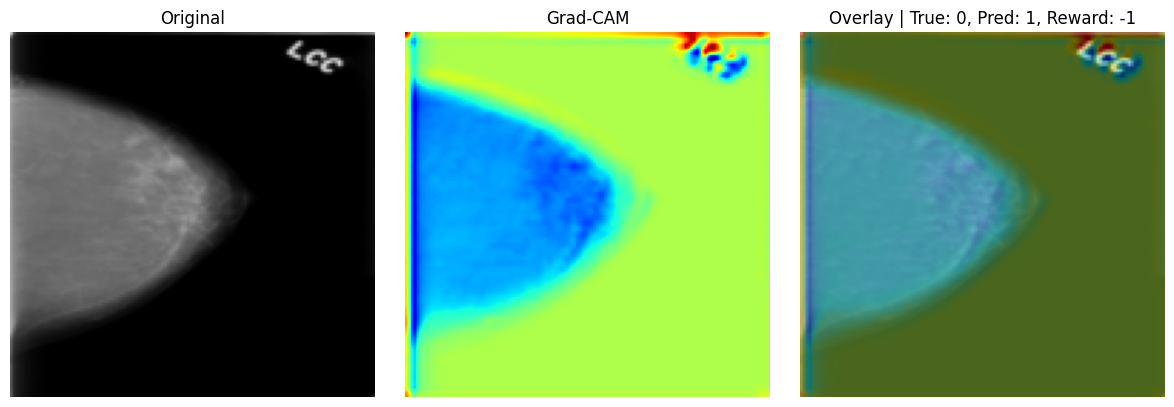

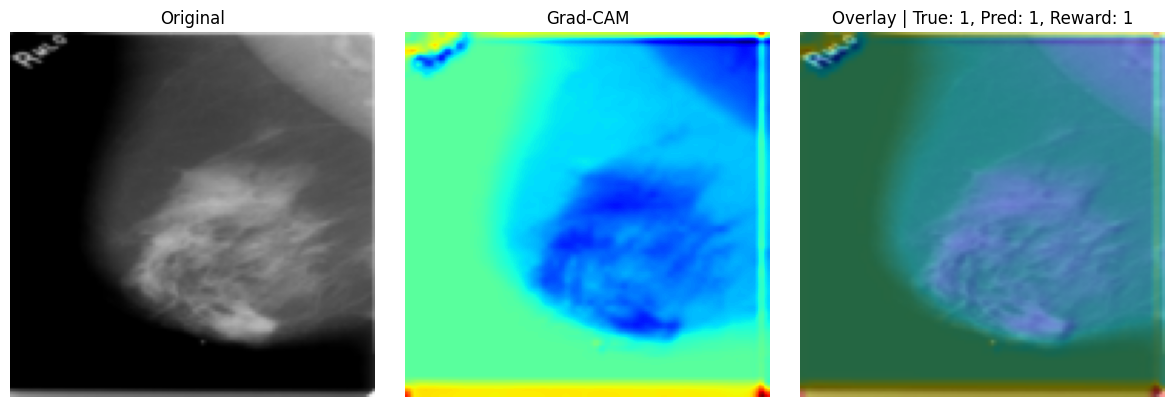

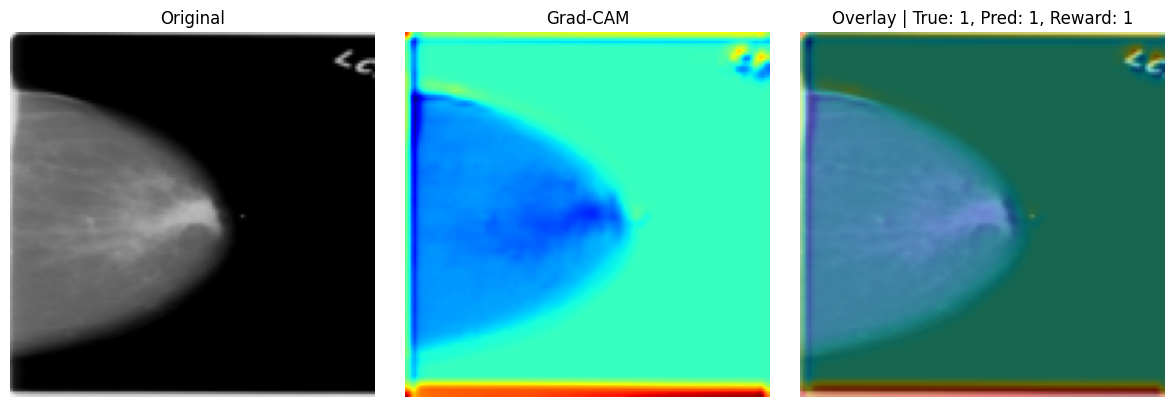

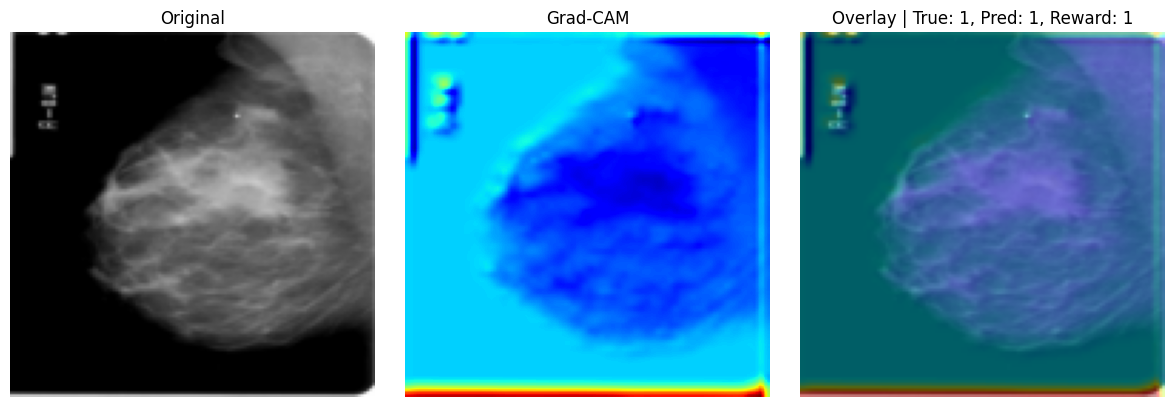

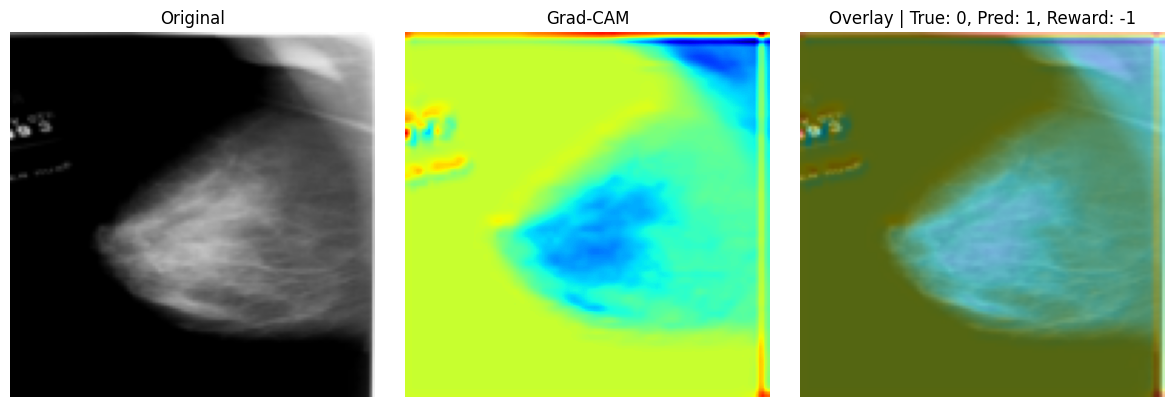

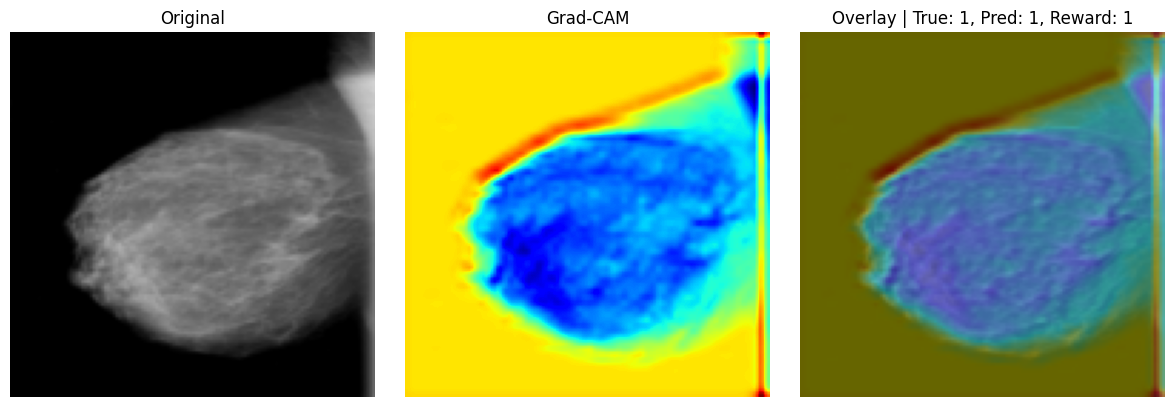

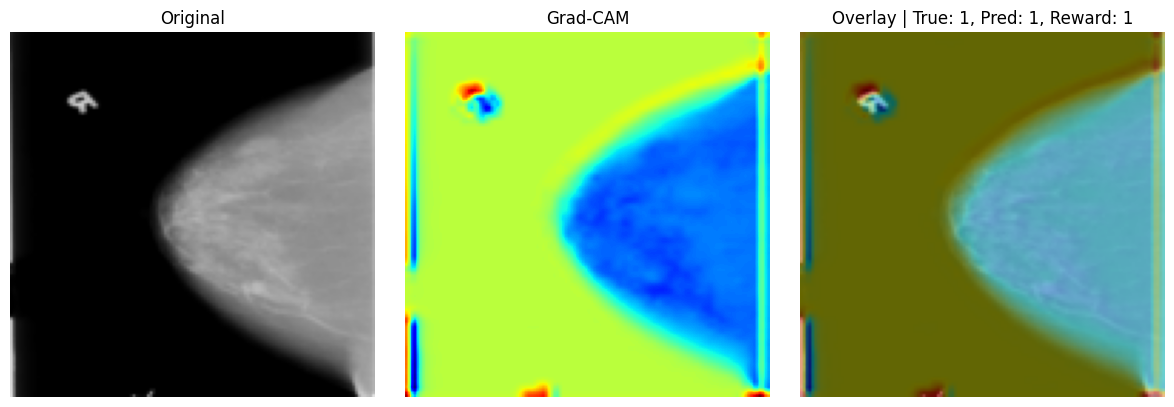

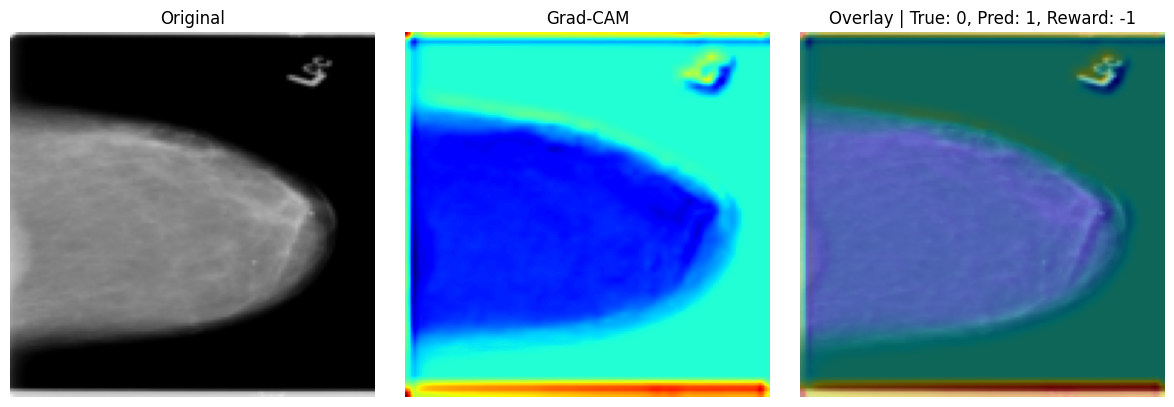

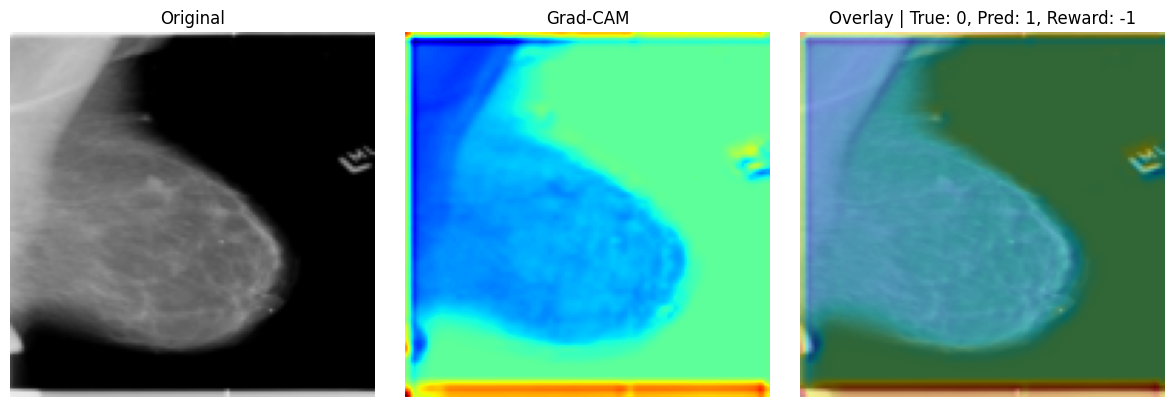

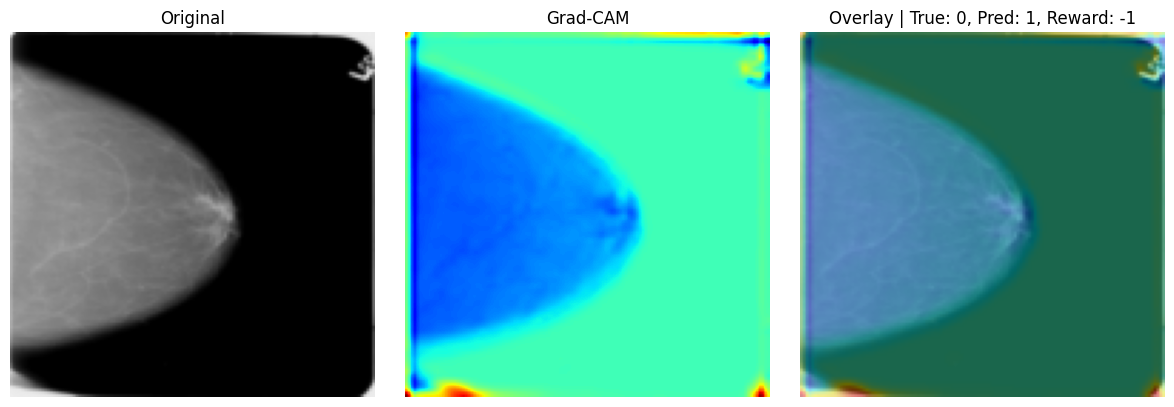

In [153]:
# Запустите полный анализ
print("Запускаем полный walkthrough с рабочей версией Grad-CAM...")
kaggle_walkthrough(model, images, labels, steps=10, use_simple=True)

In [154]:
import imageio

frames = [imageio.imread(f"walkthrough/step_{i}.png") for i in range(10)]
imageio.mimsave("agent_walk.gif", frames, duration=0.7)


/tmp/ipykernel_35/2258634974.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(f"walkthrough/step_{i}.png") for i in range(10)]


🔍 Найдено 175 пар изображение-метка
🔄 Загрузка данных...
✅ Загружено 175 изображений
📊 Train: 140, Validation: 35
🖥️ Устройство: cuda
🤖 Создание модели PPO...
Using cuda device
🚀 Начало обучения...

📈 Шаг обучения 0-1000
Logging to ./logs/PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.06     |
| time/              |          |
|    fps             | 386      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------

📊 Валидация на шаге 1000:
Точность: 37.14%
TP: 13, TN: 0, FP: 22, FN: 0
✅ Лучшая модель сохранена

📈 Шаг обучения 1000-2000
Logging to ./logs/PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.06     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 1        |
|    time_elapsed    | 4    

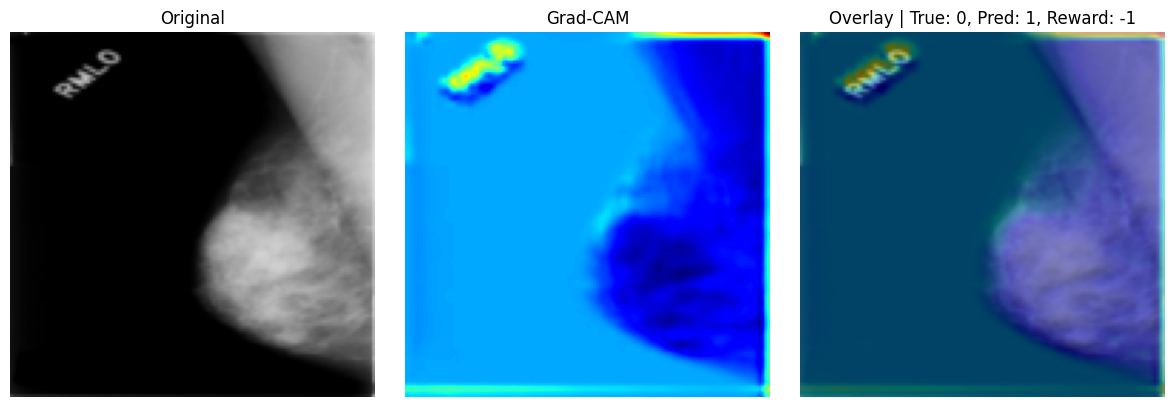

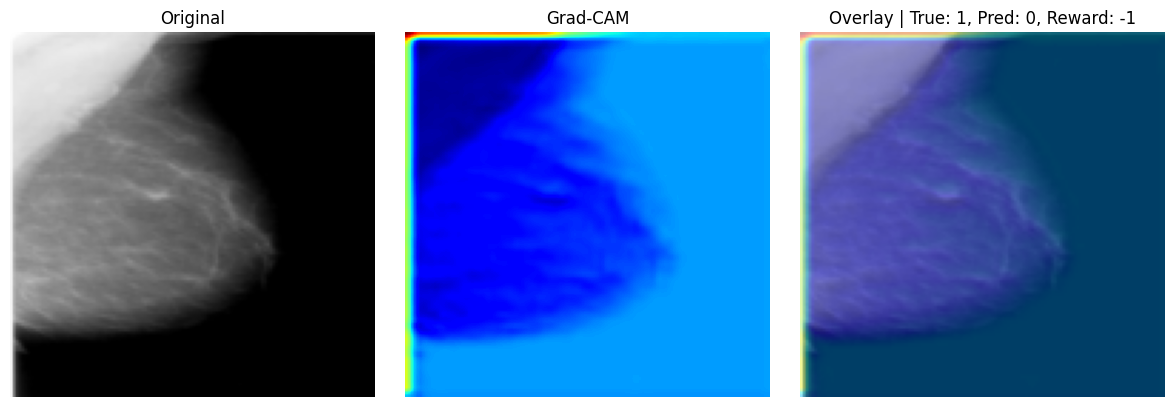

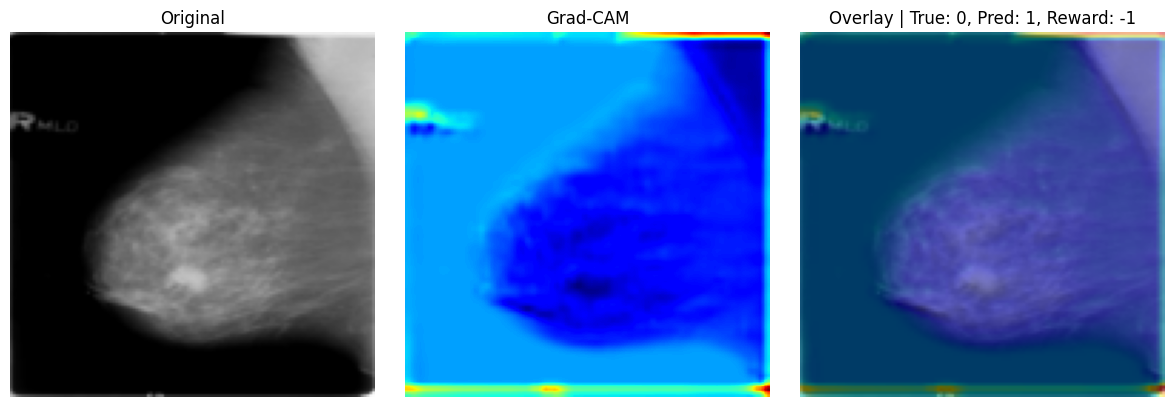

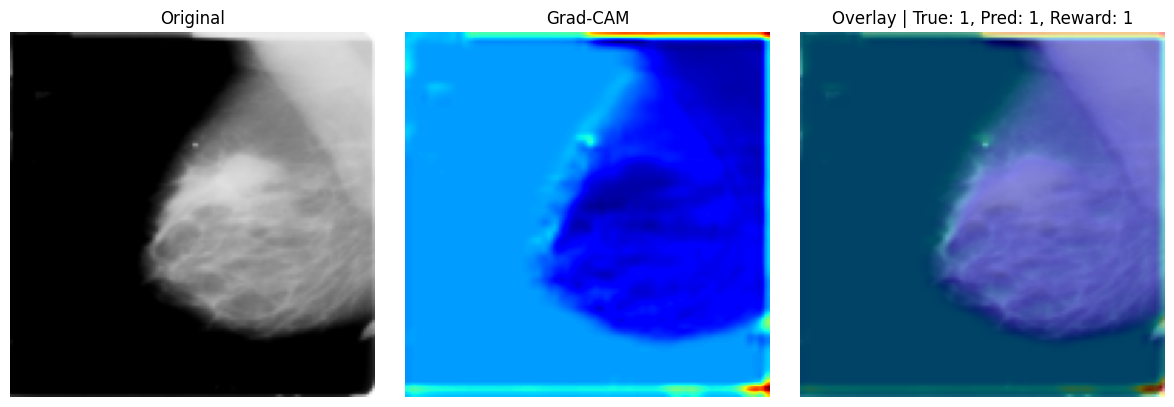

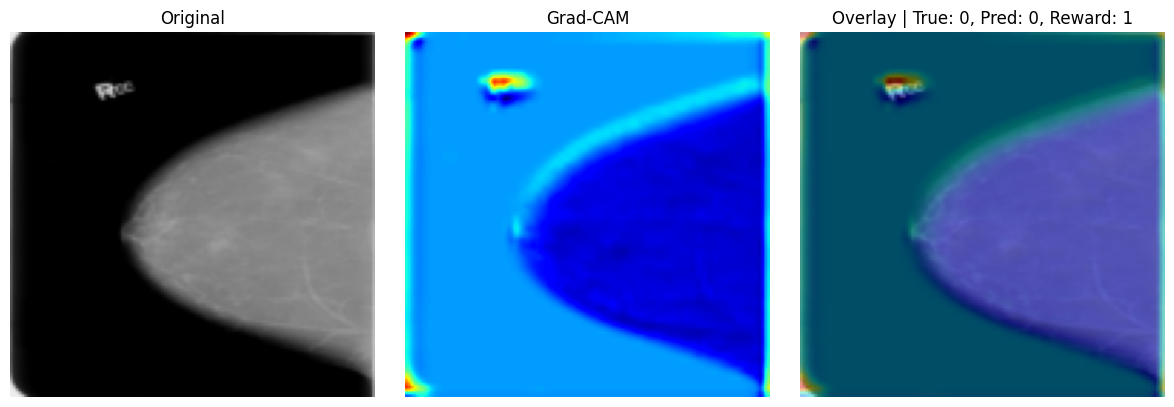

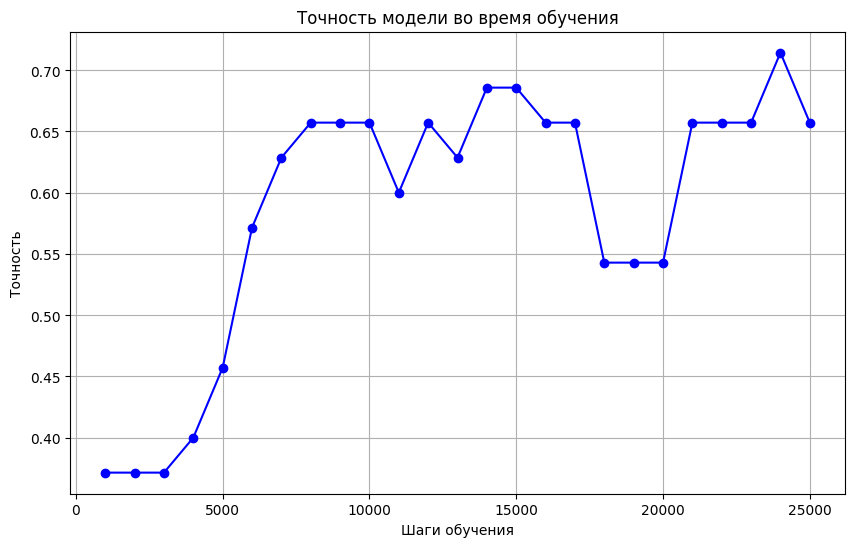

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

from PIL import Image
from torchvision import transforms
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import make_vec_env
from gymnasium import spaces
import gymnasium as gym

# === 1. Кастомный CNN для Grad-CAM ===
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        self.conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, features_dim),
            nn.ReLU()
        )
        self.activations = None

    def forward(self, x):
        x = self.conv(x)
        self.activations = x  # сохраняем активации
        return self.linear(x)

# === 2. Препроцессинг ===
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# === 3. Окружение ===
class DummyImageEnv(gym.Env):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.observation_space = spaces.Box(0, 1, shape=(3, 128, 128), dtype=np.float32)
        self.action_space = spaces.Discrete(2)
        self.idx = 0

    def reset(self, *, seed=None, options=None):
        self.idx = np.random.randint(0, len(self.images))
        return self.images[self.idx], {}

    def step(self, action):
        true_label = self.labels[self.idx]
        reward = 1 if action == true_label else -1
        done = True
        return self.images[self.idx], reward, done, False, {}

# === 4. Функция оценки модели ===
def evaluate_model_full(model, images_tensor, labels, file_names=None):
    """
    Полная оценка модели с метриками
    """
    model.policy.eval()
    
    predictions = []
    true_labels = []
    
    # Получаем предсказания для всех изображений
    for i in range(len(images_tensor)):
        img = images_tensor[i].unsqueeze(0).cpu().numpy()
        pred, _ = model.predict(img, deterministic=True)
        predictions.append(pred[0])
        true_labels.append(labels[i])
    
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    # Вычисляем метрики
    tp = np.sum((predictions == 1) & (true_labels == 1))
    tn = np.sum((predictions == 0) & (true_labels == 0))
    fp = np.sum((predictions == 1) & (true_labels == 0))
    fn = np.sum((predictions == 0) & (true_labels == 1))
    
    accuracy = (tp + tn) / len(true_labels) if len(true_labels) > 0 else 0
    
    return accuracy, tp, tn, fp, fn, predictions, true_labels

# === 5. Grad-CAM функции ===
def generate_grad_cam_simple(model, image_tensor, target_class):
    """
    Упрощенная версия Grad-CAM
    """
    try:
        model.policy.eval()
        
        if len(image_tensor.shape) == 3:
            image_tensor = image_tensor.unsqueeze(0)
        
        device = next(model.policy.parameters()).device
        image_tensor = image_tensor.to(device)
        
        # Получаем предсказание
        pred, _ = model.predict(image_tensor.cpu().numpy(), deterministic=True)
        
        # Создаем карту активации на основе conv слоя
        activations = {}
        
        def hook_fn(module, input, output):
            activations['features'] = output
        
        # Регистрируем hook на последний conv слой
        conv_layers = []
        for module in model.policy.features_extractor.modules():
            if isinstance(module, nn.Conv2d):
                conv_layers.append(module)
        
        if conv_layers:
            handle = conv_layers[-1].register_forward_hook(hook_fn)
            
            # Прямой проход
            with torch.no_grad():
                _ = model.policy.features_extractor(image_tensor)
            
            handle.remove()
            
            if 'features' in activations:
                features = activations['features']
                
                # Простое усреднение по каналам
                cam = torch.mean(features, dim=1).squeeze()
                cam = cam.detach().cpu().numpy()
                
                # Нормализация
                if cam.max() > cam.min():
                    cam = (cam - cam.min()) / (cam.max() - cam.min())
                
                # Изменение размера
                cam = cv2.resize(cam, (128, 128))
                return cam
        
        return np.zeros((128, 128))
        
    except Exception as e:
        print(f"Ошибка в simple grad-cam: {e}")
        return np.zeros((128, 128))

def kaggle_walkthrough(model, images, labels, steps=10):
    """
    Демонстрация работы модели с Grad-CAM визуализацией
    """
    os.makedirs("walkthrough", exist_ok=True)
    
    for i in range(min(steps, len(images))):
        try:
            img = images[i]
            label = labels[i]
            
            # Получаем предсказание
            pred, _ = model.predict(img.unsqueeze(0).cpu().numpy(), deterministic=True)
            reward = 1 if pred[0] == label else -1
            
            # Генерируем Grad-CAM
            cam = generate_grad_cam_simple(model, img, target_class=pred[0])
            
            # Подготовка изображения для визуализации
            img_cpu = img.cpu()
            orig = img_cpu.permute(1, 2, 0).numpy()
            orig = np.clip(orig, 0, 1)
            
            # Применяем цветовую карту к Grad-CAM
            if cam.max() > 0:
                cam_colored = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
                cam_colored = cam_colored.astype(np.float32) / 255.0
                
                # Создаем наложение
                orig_rgb = (orig * 255).astype(np.uint8)
                cam_bgr = cv2.cvtColor(cam_colored.astype(np.float32), cv2.COLOR_BGR2RGB)
                cam_bgr = (cam_bgr * 255).astype(np.uint8)
                
                overlay = cv2.addWeighted(orig_rgb, 0.6, cam_bgr, 0.4, 0)
            else:
                overlay = (orig * 255).astype(np.uint8)
                cam = np.zeros((128, 128))
            
            # Сохраняем изображение
            cv2.imwrite(f"walkthrough/step_{i}.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
            
            # Отображаем результат
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 3, 1)
            plt.title("Original")
            plt.imshow(orig)
            plt.axis("off")
            
            plt.subplot(1, 3, 2)
            plt.title("Grad-CAM")
            plt.imshow(cam, cmap='jet')
            plt.axis("off")
            
            plt.subplot(1, 3, 3)
            plt.title(f"Overlay | True: {label}, Pred: {pred[0]}, Reward: {reward}")
            plt.imshow(overlay)
            plt.axis("off")
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Ошибка на шаге {i}: {e}")
            continue

# === 6. ГЛАВНАЯ ФУНКЦИЯ ОБУЧЕНИЯ ===
def train_ppo_with_gradcam(image_paths, label_paths):
    """
    Полная функция обучения PPO с Grad-CAM
    """
    
    # Загрузка данных
    print("🔄 Загрузка данных...")
    images = []
    labels = []
    file_names = []
    
    for img_path, lbl_path in zip(image_paths, label_paths):
        try:
            # Загружаем изображение
            image = Image.open(img_path).convert("RGB")
            images.append(transform(image))
            
            # Загружаем метку
            with open(lbl_path) as f:
                label = int(f.readline().split()[0])
                labels.append(label)
            
            # Сохраняем имя файла
            file_names.append(os.path.basename(img_path))
            
        except Exception as e:
            print(f"Ошибка при загрузке {img_path}: {e}")
            continue
    
    print(f"✅ Загружено {len(images)} изображений")
    
    # Разделение на train/validation
    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    train_labels = labels[:split_idx]
    valid_images = images[split_idx:]
    valid_labels = labels[split_idx:]
    valid_file_names = file_names[split_idx:]
    
    print(f"📊 Train: {len(train_images)}, Validation: {len(valid_images)}")
    
    # Создание окружения
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🖥️ Устройство: {device}")
    
    train_env = lambda: DummyImageEnv(train_images, train_labels)
    vec_env = make_vec_env(train_env, n_envs=1)
    
    # ИСПРАВЛЕННЫЕ policy_kwargs
    policy_kwargs = dict(
        features_extractor_class=CustomCNN,
        features_extractor_kwargs=dict(features_dim=64),  # ← ИСПРАВЛЕНО: 64 вместо 128
        normalize_images=False
    )
    
    # Создание модели
    print("🤖 Создание модели PPO...")
    model = PPO("CnnPolicy", vec_env, policy_kwargs=policy_kwargs, verbose=1, tensorboard_log="./logs")
    
    # Тренировочный цикл
    print("🚀 Начало обучения...")
    best_acc = 0
    val_history = []
    total_steps = 25_000
    validation_interval = 1_000
    valid_tensor = torch.stack(valid_images)
    
    for step in range(0, total_steps, validation_interval):
        print(f"\n📈 Шаг обучения {step}-{step + validation_interval}")
        
        # Обучение
        model.learn(total_timesteps=validation_interval, reset_num_timesteps=False)
        
        # Валидация
        acc, tp, tn, fp, fn, preds, trues = evaluate_model_full(
            model, valid_tensor, valid_labels, valid_file_names
        )
        
        val_history.append({
            "step": step + validation_interval,
            "accuracy": acc,
            "tp": tp, "tn": tn, "fp": fp, "fn": fn
        })
        
        print(f"\n📊 Валидация на шаге {step + validation_interval}:")
        print(f"Точность: {acc * 100:.2f}%")
        print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
        
        # Сохранение лучшей модели
        if acc > best_acc:
            best_acc = acc
            model.save("best_model_ppo")
            print("✅ Лучшая модель сохранена")
    
    print(f"\n🎯 Обучение завершено! Лучшая точность: {best_acc * 100:.2f}%")
    
    # Демонстрация с Grad-CAM
    print("\n🔍 Демонстрация с Grad-CAM...")
    kaggle_walkthrough(model, valid_images, valid_labels, steps=5)
    
    return model, val_history

# === 7. ПРИМЕР ИСПОЛЬЗОВАНИЯ ===
if __name__ == "__main__":
    # ЗАМЕНИТЕ НА ВАШИ ПУТИ
    base_path = "/kaggle/input/cbis-dataset/valid"
    image_dir = f"{base_path}/images"
    label_dir = f"{base_path}/labels"
    
    # Получаем списки файлов
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    image_paths = [os.path.join(image_dir, f) for f in image_files]
    label_paths = [os.path.join(label_dir, f.replace('.jpg', '.txt')) for f in image_files]
    
    # Фильтруем только существующие файлы
    existing_pairs = []
    for img_path, lbl_path in zip(image_paths, label_paths):
        if os.path.exists(img_path) and os.path.exists(lbl_path):
            existing_pairs.append((img_path, lbl_path))
    
    if len(existing_pairs) > 0:
        img_paths, lbl_paths = zip(*existing_pairs)
        print(f"🔍 Найдено {len(existing_pairs)} пар изображение-метка")
        
        # Запуск обучения
        model, history = train_ppo_with_gradcam(img_paths, lbl_paths)
        
        # Построение графика обучения
        plt.figure(figsize=(10, 6))
        steps = [h['step'] for h in history]
        accuracies = [h['accuracy'] for h in history]
        plt.plot(steps, accuracies, 'b-', marker='o')
        plt.title('Точность модели во время обучения')
        plt.xlabel('Шаги обучения')
        plt.ylabel('Точность')
        plt.grid(True)
        plt.show()
        
    else:
        print("❌ Не найдены файлы данных. Проверьте пути.")
        
        # Альтернативный запуск с существующими данными
        print("🔄 Пробуем использовать уже загруженные данные...")
        if 'images' in globals() and 'labels' in globals():
            print("✅ Найдены предварительно загруженные данные")
            
            # Создаем фиктивные пути
            fake_img_paths = [f"image_{i}.jpg" for i in range(len(images))]
            fake_lbl_paths = [f"label_{i}.txt" for i in range(len(labels))]
            
            # Запускаем обучение
            model, history = train_ppo_with_gradcam(fake_img_paths, fake_lbl_paths)

In [3]:
import imageio
frames = [imageio.imread(f"walkthrough/step_{i}.png") for i in range(10)]
imageio.mimsave("agent_walk.gif", frames, duration=0.7)


/tmp/ipykernel_35/2258634974.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames = [imageio.imread(f"walkthrough/step_{i}.png") for i in range(10)]


FileNotFoundError: No such file: '/kaggle/working/walkthrough/step_5.png'

In [156]:
obs = vec_env.reset()
print(obs.shape)  # (1, 3, 128, 128)


(1, 3, 128, 128)


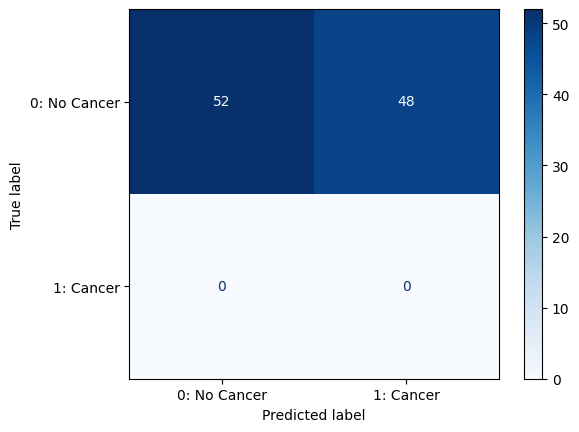

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(truths, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0: No Cancer", "1: Cancer"])
disp.plot(cmap="Blues")


# Validation